# Scikit-learn + Dask

Scikit-learn is a popular machine learning library whose API is easy to use. It encompasses a wide variety of problem formulations, ranging from simple data preperation tasks to various decompositions. Scikit-learn works great for problems that fit on a single machine, but struggles for larger problems. This has even gotten a page in their user guide, "[Strategies to scale computationally: bigger data][strat]".

Using scikit-learn estimators with Dask-ML helps scale to large datasets. All the computation remains on scikit-learn's shoulders but the data management is handled by Dask. This allows scaling to large datasets distributed across many machines, or to datasets that do not fit in memory.

This example will show

* wrapping a scikit-learn estimator that implements `partial_fit` with [dask_ml.wrappers.Incremental]
* training, predicting, and scoring on this wrapped classifier
* integration with other parts of scikit-learn (i.e., with GridSearchCV)

[dask_ml.wrappers.Incremental]:https://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.wrappers.Incremental.html#dask_ml.wrappers.Incremental

Though this example is made with a scikit-learn estimator, it will work for any class that implements `partial_fit` and the [scikit-learn base estimator API].

[scikit-learn base estimator API]:http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html

<img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png">
<img src="https://www.continuum.io/sites/default/files/dask_stacked.png" width="100px">

[strat]:http://scikit-learn.org/stable/modules/scaling_strategies.html


## Dask setup

Creating a distributed scheduler will provide good feedback because we can view the dask.distributed dashboard. This will provide progress and performance metrics, including visualization of jobs that are running.

In [1]:
from distributed import Client, LocalCluster
client = Client()
client

Client Scheduler: tcp://127.0.0.1:57410 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


## Data creation
We will create synthetic data because we are more interested in showing how these data flow through the estimator, rather than any insights we can glean from the data.

Let's create a synthetic dataset that's not too large (so it runs in a reasonable time) and but is realistically large and can show Dask features. We have 100,000 examples and 100 features in this dataset we create:

In [2]:
import numpy as np
import dask.array as da
from dask_ml.datasets import make_classification
import dask

n, d = 100000, 100

X, y = make_classification(n_samples=n, n_features=d,
                           chunks=n // 10)
X

dask.array<normal, shape=(100000, 100), dtype=float64, chunksize=(10000, 100)>

If this were a real use case, the Dask arrays `X` and `y` would be real data (e.g., from file system or a database). There are many methods to create Dask arrays (https://dask.pydata.org/en/latest/array-creation.html) and Dask dataframes (https://dask.pydata.org/en/latest/dataframe-create.html).

## Data splitting for training and testing
We are interested in evaluating this model, so we don't want to learn from test data. This prevents against that.

In [3]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train

dask.array<concatenate, shape=(90000, 100), dtype=float64, chunksize=(9000, 100)>

We haven't done any work yet – Dasks operations are lazy, so we've only described to Dask what we want to do. When we tell Dask we want to do work, it'll be done in parallel on a worker or out-of-core.

## Create Scikit-Learn model

We make the underlying scikit-learn estimator:

In [6]:
from sklearn.linear_model import SGDClassifier

est = SGDClassifier(loss='log', penalty='l1', tol=1e-3, average=True)

This estimator must implement `partial_fit` to be wrapped with [Dask-ML's Incremental][1]. A list of models that implement this API is available on a scikit-learn documentation page under "Incremental learning": http://scikit-learn.org/stable/modules/scaling_strategies.html#incremental-learning

[1]:https://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.wrappers.Incremental.html#dask_ml.wrappers.Incremental

## Wrap Scikit-Learn with Dask-ML

Now, let's wrap it with `dask_ml.wrappers.Incremental`: https://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.wrappers.Incremental.html#dask_ml.wrappers.Incremental. `Incremental` is a meta-estimator, or an estimator that takes in another estimator.

In [7]:
from dask_ml.wrappers import Incremental

inc = Incremental(est, scoring='accuracy')

`Incremental` does data management: it calls `est.partial_fit` on each chunk of the passed data. Dask moves the model to different chunks of the data (or vice versa) to let this happen. Note: Dask-ML `Incremental` gives data to Scikit-learn and does not change the underlying optimization algorithm that Scikit-learn uses (though there are other estimators in Dask-ML that do this for specific formulations).

It is important to specify the scoring parameter in `Incremental`; otherwise, scikit-learn scorers are fed Dask arrays (which they're not optimized for).


[1]:http://scikit-learn.org/stable/modules/scaling_strategies.html
[inc]:http://scikit-learn.org/stable/modules/scaling_strategies.html#incremental-learning

## Model training

`Incremental` implements a `fit` method, which will perform one loop over the dataset, calling `partial_fit` over each chunk in the Dask array.

In [24]:
inc.fit(X_train, y_train, classes=classes)

Incremental(estimator=SGDClassifier(alpha=0.0001, average=True, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.0, verbose=0, warm_start=False),
      random_state=None, scoring='accuracy', shuffle_blocks=True)

### Calling `partial_fit`
Let's call `partial_fit` multiple times because this is an incremental classifier. 
#### Persisting the data

This does require calling `persist` on the data for performance. This can happen because this dataset is small enough to fit in distributed memory. This will compute the data and put into memory, which has some real benefits. It will not need to perform computation to pull the data everytime it is referenced.

In [ ]:
X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)

If we didn't call `persist`, this data would have to be recomputed every time. Calling `persist` makes this training about 3x faster.

This is especially relevant with `classes`, which is required for our `partial_fit` call. This requires a full pass over the dataset. Because `classes` is a small object and there are only two classes, we'll call `compute` instead of `persist`.

In [25]:
classes = da.unique(y).compute()
classes

array([0, 1])

#### Training

We'll create and run many small graphs at once in a for-loop, even though Dask prefers to create one large graph before running. 

Now we can call `partial_fit` multiple times. Before we do that, we'll have to create our estimators `est` and `inc` because they've already been fitted through above.

In [26]:
est = SGDClassifier(loss='hinge', penalty='l2', tol=0e-3, average=True)
inc = Incremental(est, scoring='accuracy')

And now for calling `partial_fit` multiple times and collecting some metadata.

In [27]:
from distributed.metrics import time

data = []
start = time()
for epoch in range(10):
    inc.partial_fit(X_train, y_train, classes=classes)
    inc.score(X_test, y_test)
    data += [{'epoch': epoch,
              'test_score': inc.score(X_test, y_test),
              'time': time() - start}]
    print(data[-1])

{'epoch': 0, 'test_score': 0.6641, 'time': 0.31238818168640137}
{'epoch': 1, 'test_score': 0.666, 'time': 0.6242408752441406}
{'epoch': 2, 'test_score': 0.6664, 'time': 0.9747679233551025}
{'epoch': 3, 'test_score': 0.6667, 'time': 1.2866020202636719}
{'epoch': 4, 'test_score': 0.6677, 'time': 1.6056740283966064}
{'epoch': 5, 'test_score': 0.6665, 'time': 1.934689998626709}
{'epoch': 6, 'test_score': 0.6666, 'time': 2.253448009490967}
{'epoch': 7, 'test_score': 0.6667, 'time': 2.5694589614868164}
{'epoch': 8, 'test_score': 0.6668, 'time': 2.889284133911133}
{'epoch': 9, 'test_score': 0.6671, 'time': 3.247598171234131}


This for-loop is simple, even though it's doing a fairly complex operation. One could imagine having each iteration of this for-loop to be complicated and manage data IO as well as giving the estimator different chunks. With distributed, the IO cost is paid once at the beginning then not once again.

And we can plot the test scores over different training iterations:

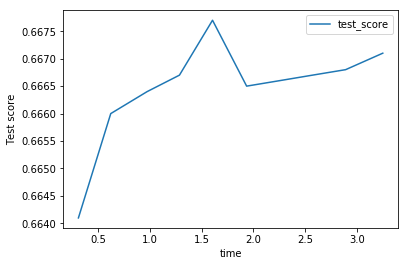

In [29]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
df.plot(x='time', y='test_score')
_ = plt.ylabel('Test score')

## Scoring

We can also call `Incremental.score` to compute the accuracy for us:

In [30]:
inc.score(X_test, y_test)

0.6671

This accuracy can also be computed by seeing where `inc.pred(X_test)` is not equal to `y_test`. For more details on how to do this with raw dask arrays, see the array example.

## Learn more
### Model selection
Model selection is often a critical task because (almost) every estimator has many parameters to configure even before fitting starts. These values typically have defaults but can drastically affect performance. Ways to tune these parameters are through scikit-learns GridSearchCV and RandomizedSearchCV.

dask-searchcv is a drop in replacement and optimizes scikit-learn's GridSearchCV and RandomizedSearchCV. For more detail, see https://dask-searchcv.readthedocs.io/en/latest/

### Dask + scikit-learn's parallel engine
Scikit-learn depends on joblib for it's parallelism. It's often available by specifying a `n_jobs` keyword (e.g., in [sklearn.model_selection.GridSearchCV][1]). Dask can serve as a joblib backend, meaning that anytime joblib is called it gets routed to Dask. For more detail, see https://dask-ml.readthedocs.io/en/latest/joblib.html

[1]:http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html